In [44]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib

In [45]:
def pwm2Thrust(pwm):
    thrust = 0.5*(pwm-1500)
    return thrust

def getThrustForce(thrusters, changeThrust):
    newThrusters = thrusters + changeThrust
    thrust = np.zeros(8)
    
    for i in range(0,len(thrusters)):
        if newThrusters[i] > 1900:
            newThrusters[i] = 1900
        elif newThrusters[i] < 1100:
            newThrusters[i] = 1100
        thrust[i] = pwm2Thrust(newThrusters[i])
    return thrust
        

def reorient(thrusterForce, thrusterDir, thrusterPos, I, disturbance, disturbancePos):
    moment = np.zeros(3)
    for i in range(0, len(thrusterForce)):
        moment = moment + np.cross(thrusterPos[i], thrusterForce[i]*thrusterDir[i])
    moment = moment + np.cross(disturbancePos, disturbance)
    angAcc = np.matmul(np.linalg.inv(I), moment)
    return angAcc

def move(thrusterForce, thrustDir, mass, extForce):
    force = np.zeros(3)
    for i in range(0, len(thrusterForce)):
        force = force + thrusterForce[i]*thrustDir[i]

    
    force = force + extForce
    acc = force/mass
    return acc

def newState(auvPos, auvVel, auvOrientation, auvAngVel, auvAcc, auvAngAcc, dt):
    newAUVPos = np.zeros(3)
    newAUVVel = np.zeros(3)
    newAUVOrientation = np.zeros(3)
    newAUVAngVel = np.zeros(3)
    
    newAUVAngVel = auvAngVel + auvAngAcc * dt
    newAUVOrientation = auvOrientation + (newAUVAngVel + auvAngVel)/2 * dt

    
    moveOrientation = (newAUVOrientation + auvOrientation)/2
    
#     newAUVOrientation = np.round(newAUVOrientation,3)
    
#     for i in range(0, len(moveOrientation)):
#         while moveOrientation[i] > 2*np.pi:
#             moveOrientation[i] = moveOrientation[i] - 2*np.pi
#         while newAUVOrientation[i] > 2*np.pi:
#             newAUVOrientation[i] = newAUVOrientation[i] - 2*np.pi
#         while moveOrientation[i] < 0:
#             moveOrientation[i] = moveOrientation[i] + 2*np.pi
#         while newAUVOrientation[i] < 0:
#             newAUVOrientation[i] = newAUVOrientation[i] + 2*np.pi
    
    xAngle = moveOrientation[0]
    yAngle = moveOrientation[1]
    zAngle = moveOrientation[2]
    Rx = np.array([[1,0,0],[0, np.cos(xAngle), -np.sin(xAngle)], [0, np.sin(xAngle), np.cos(xAngle)]])
    Ry = np.array([[np.cos(yAngle), 0, np.sin(yAngle)], [0, 1, 0], [-np.sin(yAngle), 0, np.cos(yAngle)]])
    Rz = np.array([[np.cos(zAngle), -np.sin(zAngle), 0], [np.sin(zAngle), np.cos(zAngle), 0], [0, 0, 1]])
    auvAcc = (Rz) @ (Ry) @ (Rx) @ auvAcc
    newAUVVel = auvVel + auvAcc*dt
    newAUVPos = auvPos + (newAUVVel + auvVel)/2*dt
    
    return newAUVPos, newAUVVel, newAUVOrientation, newAUVAngVel

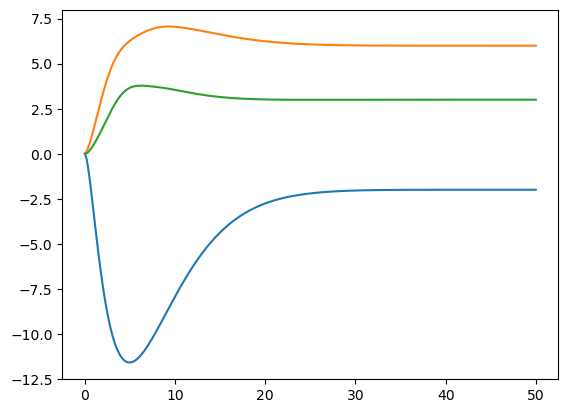

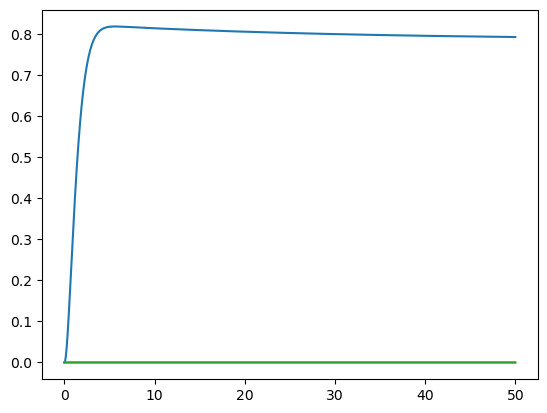

In [46]:
dir1 = np.array([np.cos(np.pi/4), np.sin(np.pi/4), 0])
dir2 = np.array([-np.cos(np.pi/4), np.sin(np.pi/4), 0])
dir3 = np.array([0, 0, 1])
dir4 = np.array([0, 0, -1])
dir5 = np.array([0, 0, -1])
dir6 = np.array([0, 0, 1])
dir7 = np.array([-np.cos(np.pi/4), np.sin(np.pi/4), 0])
dir8 = np.array([np.cos(np.pi/4), np.sin(np.pi/4), 0])
thrustDir = np.array([dir1, dir2, dir3, dir4, dir5, dir6, dir7, dir8])

#Thruster positions, with respect to center of mass of AUV
thruster1Pos = [-0.15, 0.3, 0]
thruster2Pos = [0.15, 0.3, 0]
thruster3Pos = [-0.15, 0.15, 0]
thruster4Pos = [0.15, 0.15, 0]
thruster5Pos = [-0.15, -0.15, 0]
thruster6Pos = [0.15, -0.15, 0]
thruster7Pos = [-0.15, -0.3, 0]
thruster8Pos = [0.15, -0.3, 0]
thrusterPos = np.array([thruster1Pos, thruster2Pos, thruster3Pos, thruster4Pos, thruster5Pos, thruster6Pos, thruster7Pos, thruster8Pos])

zControl = np.array([0, 0, 1, -1, -1, 1, 0, 0])
yControl = np.array([1, 1, 0, 0, 0, 0, 1, 1])
xControl = np.array([1, -1, 0, 0, 0, 0, -1, 1])
rollControl = np.array([0, 0, 1, -1, 1, -1, 0, 0])
pitchControl = np.array([0, 0, 1, 1, -1, -1, 0, 0])
yawControl = np.array([-1, 1, 0, 0, 0, 0, -1, 1])

m = 10 #kg
Ixx = 0.5
Ixy = 0
Ixz = 0
Iyy = 2
Iyz = 0
Izz = 1
Iyx = Ixy
Izx = Ixz
Izy = Iyz
I = np.array([[Ixx, Ixy, Ixz], [Iyx, Iyy, Iyz], [Izx, Izy, Izz]])

dt = 0.01 #s
time = np.arange(0,50,dt)
auvPos = np.zeros([len(time), 3])
auvVel = np.array([0,0,0])
auvOrientation = np.zeros([len(time), 3]) #roll, pitch, yaw
auvOrientation[0,1] = 0
auvOrientation[0,0] = 0
auvAngularVel = np.array([0,0,0])
thrusters = np.array([1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500])
changeThrust = np.array([0,0,0,0,0,0,0,0])
thrustersThrust = np.zeros(8)

disturbance = np.zeros(3)
disturbancePos = np.zeros(3)
extForce = np.zeros(3)
g = 9.8 #m/s^2
gForce = [0,0,-m*g]
extForce = gForce

Kp = 4
Kpd = 10
Kpi = 0.5

Kap = 3
Kad = 4
Kai = 0.1

targetX = 3
targetY = 6
targetZ = -2
targetRoll = 0
targetPitch = 0
targetYaw = np.pi/4
targetPos = np.array([targetX, targetY, targetZ])
targetAngle = np.array([targetRoll, targetPitch, targetYaw])
posErr = 0
prevPosErr = 0
trackPosErr = 0
angErr = 0
prevAngErr = 0
trackAngErr = 0

for i in range(0,len(time)-1):
    posErr = targetPos - auvPos[i]
    diffPosErr = posErr-prevPosErr
    trackPosErr = trackPosErr + posErr
    u = posErr*Kp + diffPosErr/dt*Kpd + trackPosErr*Kpi*dt
    
    angErr = targetAngle - auvOrientation[i]
    diffAngErr = angErr - prevAngErr
    trackAngErr = trackAngErr + angErr
    t = angErr*Kap + diffAngErr/dt*Kad + trackAngErr*dt*Kai
    
    changeThrust = u[0]*xControl + u[1]*yControl + u[2]*zControl + t[0]*rollControl + t[1]*pitchControl + t[2]*yawControl
    
    thrustersThrust = getThrustForce(thrusters, changeThrust)
    auvAngAcc = reorient(thrustersThrust, thrustDir, thrusterPos, I, disturbance, disturbancePos)
    auvAcc = move(thrustersThrust, thrustDir, m, extForce)
    [auvPos[i+1], auvVel, auvOrientation[i+1], auvAngularVel] = newState(auvPos[i], auvVel, auvOrientation[i], auvAngularVel, auvAcc, auvAngAcc, dt)
    
    prevPosErr = posErr
    prevAngErr = angErr

plt.figure(1)
plt.plot(time,auvPos[:,2])
plt.plot(time,auvPos[:,1])
plt.plot(time,auvPos[:,0])
plt.figure(2)
plt.plot(time,auvOrientation[:,2])
plt.plot(time,auvOrientation[:,1])
plt.plot(time,auvOrientation[:,0])
    
    



In [54]:
a = np.array([1,2,3])
b = np.array([[4,5,6], [3,2,1], [5,8,9]])
print(a.dot(b))
print(np.matmul(a,b))
print(a @ b)
print(np.linalg.inv(b))
print(b)
print(b[1,2])

[25 33 35]
[25 33 35]
[25 33 35]
[[ 0.71428571  0.21428571 -0.5       ]
 [-1.57142857  0.42857143  1.        ]
 [ 1.         -0.5        -0.5       ]]
[[4 5 6]
 [3 2 1]
 [5 8 9]]
1


In [16]:
a = np.array([1,2,3])
b = np.array([4,5,6])
np.cross(a,b)

array([-3,  6, -3])

In [34]:
a = np.zeros([1,3])
a

array([[0., 0., 0.]])

In [66]:
a = np.zeros([8,2])
a[:,0]

array([0., 0., 0., 0., 0., 0., 0., 0.])

In [28]:
xAngle = np.pi/3
yAngle = np.pi/6
zAngle = np.pi/4
Rx = np.array([[1,0,0],[0, np.cos(xAngle), -np.sin(xAngle)], [0, np.sin(xAngle), np.cos(xAngle)]])
Ry = np.array([[np.cos(yAngle), 0, np.sin(yAngle)], [0, 1, 0], [-np.sin(yAngle), 0, np.cos(yAngle)]])
Rz = np.array([[np.cos(zAngle), -np.sin(zAngle), 0], [np.sin(zAngle), np.cos(zAngle), 0], [0, 0, 1]])
print(Rx)
print(Ry)
print(Rz)

[[ 1.         0.         0.       ]
 [ 0.         0.5       -0.8660254]
 [ 0.         0.8660254  0.5      ]]
[[ 0.8660254  0.         0.5      ]
 [ 0.         1.         0.       ]
 [-0.5        0.         0.8660254]]
[[ 0.70710678 -0.70710678  0.        ]
 [ 0.70710678  0.70710678  0.        ]
 [ 0.          0.          1.        ]]


In [51]:
dt = 0.01 #s
time = np.arange(0,250,dt)
auvPos = np.zeros([len(time), 3])
auvAngAcc = np.array([0, 0, 0])
print(len(auvPos[0]))

3


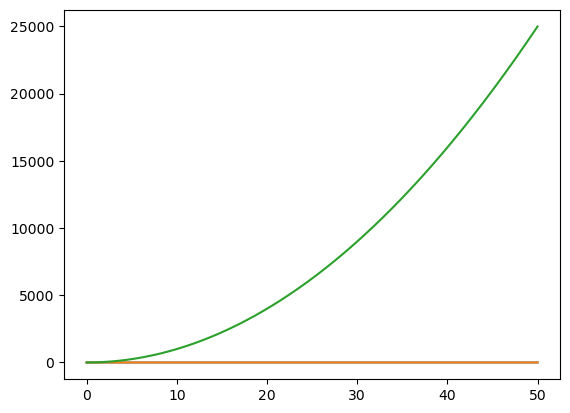

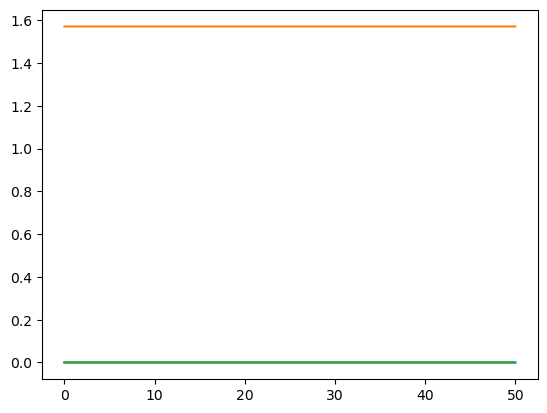

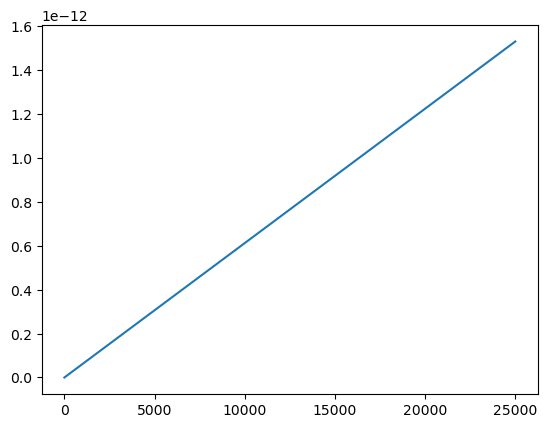

In [40]:
dir1 = np.array([np.cos(np.pi/4), np.sin(np.pi/4), 0])
dir2 = np.array([-np.cos(np.pi/4), np.sin(np.pi/4), 0])
dir3 = np.array([0, 0, 1])
dir4 = np.array([0, 0, -1])
dir5 = np.array([0, 0, -1])
dir6 = np.array([0, 0, 1])
dir7 = np.array([-np.cos(np.pi/4), np.sin(np.pi/4), 0])
dir8 = np.array([np.cos(np.pi/4), np.sin(np.pi/4), 0])
thrustDir = np.array([dir1, dir2, dir3, dir4, dir5, dir6, dir7, dir8])

#Thruster positions, with respect to center of mass of AUV
thruster1Pos = [-0.15, 0.3, 0]
thruster2Pos = [0.15, 0.3, 0]
thruster3Pos = [-0.15, 0.15, 0]
thruster4Pos = [0.15, 0.15, 0]
thruster5Pos = [-0.15, -0.15, 0]
thruster6Pos = [0.15, -0.15, 0]
thruster7Pos = [-0.15, -0.3, 0]
thruster8Pos = [0.15, -0.3, 0]
thrusterPos = np.array([thruster1Pos, thruster2Pos, thruster3Pos, thruster4Pos, thruster5Pos, thruster6Pos, thruster7Pos, thruster8Pos])

# zControl = np.array([0, 0, 1, -1, -1, 1, 0, 0])
# yControl = np.array([1, 1, 0, 0, 0, 0, 1, 1])
# xControl = np.array([1, -1, 0, 0, 0, 0, -1, 1])
# rollControl = np.array([0, 0, 1, -1, 1, -1, 0, 0])
# pitchControl = np.array([0, 0, 1, 1, -1, -1, 0, 0])
# yawControl = np.array([-1, 1, 0, 0, 0, 0, -1, 1])

m = 10 #kg
Ixx = 0.5
Ixy = 0
Ixz = 0
Iyy = 2
Iyz = 0
Izz = 1
Iyx = Ixy
Izx = Ixz
Izy = Iyz
I = np.array([[Ixx, Ixy, Ixz], [Iyx, Iyy, Iyz], [Izx, Izy, Izz]])

dt = 0.01 #s
time = np.arange(0,50,dt)
auvPos = np.zeros([len(time), 3])
auvVel = np.array([0,0,0])
auvOrientation = np.zeros([len(time), 3]) #roll, pitch, yaw
for i in range(0, len(auvOrientation)):
    auvOrientation[i,1] = np.pi/2
auvAngularVel = np.array([0,0,0])
thrusters = np.array([1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500])
changeThrust = np.array([0,0,0,0,0,0,0,0])
thrustersThrust = np.zeros(8)

disturbance = np.zeros(3)
disturbancePos = np.zeros(3)
extForce = np.zeros(3)
# # g = 9.8 #m/s^2
# # gForce = [0,0,-m*g]
# # extForce = gForce

# Kp = 4
# Kpd = 10
# Kpi = 0.5

# Kap = 3
# Kad = 2
# Kai = 0.1

# targetX = 3
# targetY = 6
# targetZ = -2
# targetRoll = 0
# targetPitch = 0
# targetYaw = np.pi/4
# targetPos = np.array([targetX, targetY, targetZ])
# targetAngle = np.array([targetRoll, targetPitch, targetYaw])
# posErr = 0
# prevPosErr = 0
# trackPosErr = 0
# angErr = 0
# prevAngErr = 0
# trackAngErr = 0

for i in range(0,len(time)-1):
    
    changeThrust = [0, 0, 100, -100, -100, 100, 0, 0]
    
    thrustersThrust = getThrustForce(thrusters, changeThrust)
    auvAngAcc = reorient(thrustersThrust, thrustDir, thrusterPos, I, disturbance, disturbancePos)
    auvAcc = move(thrustersThrust, thrustDir, m, extForce)
    [auvPos[i+1], auvVel, auvOrientation[i+1], auvAngularVel] = newState(auvPos[i], auvVel, auvOrientation[i], auvAngularVel, auvAcc, auvAngAcc, dt)

plt.figure(1)
plt.plot(time,auvPos[:,2])
plt.plot(time,auvPos[:,1])
plt.plot(time,auvPos[:,0])
plt.figure(2)
plt.plot(time,auvOrientation[:,2])
plt.plot(time,auvOrientation[:,1])
plt.plot(time,auvOrientation[:,0])
plt.figure(3)
plt.plot(auvPos[:,0], auvPos[:,2])



In [14]:
a = np.array([[1,2,3], [3,4,5], [1,2,3]])
b = np.array([[1], [2], [3]])
c = np.array([1,2,3])
a@c

array([14, 26, 14])